In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
df = pd.read_csv('vehicles.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


## Data Cleaning

In [3]:
# get information about all the columns in the dataset
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [4]:
# get information about the shape of the data matrix
df.shape

(426880, 26)

In [5]:
# get information number of data observations in the dataset columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [6]:
# check the rows in the dataset that are duplicated
df.duplicated().value_counts()

False    426880
dtype: int64

In [7]:
df.title_status.unique()

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

In [8]:
# Check the count of the values in the 'cylinders' column
Counter(df['cylinders'])

Counter({nan: 177678,
         '8 cylinders': 72062,
         '6 cylinders': 94169,
         '4 cylinders': 77642,
         '5 cylinders': 1712,
         'other': 1298,
         '3 cylinders': 655,
         '10 cylinders': 1455,
         '12 cylinders': 209})

In [9]:
# Remove the cylinders in the row values and retain the corresponding digits
df['cylinders'].replace(to_replace=['3 cylinders','4 cylinders','5 cylinders','6 cylinders','8 cylinders',
                                    '10 cylinders','12 cylinders'],
                        value=[3,4,5,6,8,10,12],inplace=True) 

In [10]:
Counter(df['cylinders'])

Counter({nan: 177678,
         8: 72062,
         6: 94169,
         4: 77642,
         5: 1712,
         'other': 1298,
         3: 655,
         10: 1455,
         12: 209})

In [11]:
# drop columns that would not be useful for now
df = df.drop(columns = ['id','url','region_url', 'image_url','county', 'VIN', 
                        'description', 'posting_date', 'size', 'lat', 'long'])

In [12]:
# check the rows in the dataset that are duplicated
df.duplicated().value_counts()

False    370389
True      56491
dtype: int64

In [13]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [14]:
# check the current shape of the dataset matrix without duplicates
df.shape

(370389, 15)

In [15]:
# check for missing values
df.isna().sum()

region               0
price                0
year               986
manufacturer     15219
model             4682
condition       141158
cylinders       150664
fuel              2437
odometer          3446
title_status      6697
transmission      2036
drive           112405
type             78824
paint_color     108655
state                0
dtype: int64

In [16]:
# drop missing values in year, model, fuel, odometer, transmission 
df.dropna(subset=['year','model','fuel','odometer','transmission'],axis=0,inplace=True)
df.shape

(358356, 15)

In [17]:
#drop all concurrent missing values in manufacturer, condition, cylinders, title status, drive, type, paint color 
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color'], axis=0, how='all', inplace=True)
df.shape

(358356, 15)

It looks like there are no rows with concurrent missing values

In [18]:
df.isna().sum()

region               0
price                0
year                 0
manufacturer     13940
model                0
condition       132792
cylinders       144164
fuel                 0
odometer             0
title_status      5438
transmission         0
drive           108043
type             75482
paint_color     103466
state                0
dtype: int64

In [19]:
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color'], axis=0, inplace=True)
df.shape

(104346, 15)

In [20]:
df.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

In [21]:
df['price'].min()

0

In [22]:
df['price'].max()

3736928711

Based on the minimum and maximum values of the price which are extreme values, it appears there are outliers

In [23]:
# view the high priced car outliers
outlier = df.loc[((df.price > 500_000) & (df.price < 100_000_000_000))]
outlier.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
29386,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8,diesel,149000.0,clean,automatic,rwd,pickup,white,ca
68935,ventura county,2000000,2002.0,saturn,l-series l200 4dr sedan,good,4,gas,164290.0,clean,automatic,fwd,sedan,green,ca
136516,spokane / coeur d'alene,17000000,2007.0,ram,2500,good,8,diesel,170000.0,rebuilt,automatic,4wd,pickup,black,id
137807,spokane / coeur d'alene,123456789,1999.0,buick,regal,like new,6,gas,96000.0,clean,automatic,fwd,sedan,white,id
155421,terre haute,1234567,2006.0,jeep,wrangler,like new,6,gas,123456.0,clean,automatic,4wd,SUV,custom,in


Looking at the price column above, the prices shown are outrageous and are not a true picture of the prices of vehicles. It is possible there were erros in data entry for these values

In [24]:
# check to see the car manufacturers that are highly priced 
outlier.manufacturer.unique()

array(['ford', 'saturn', 'ram', 'buick', 'jeep', 'dodge', 'nissan', 'gmc',
       'toyota'], dtype=object)

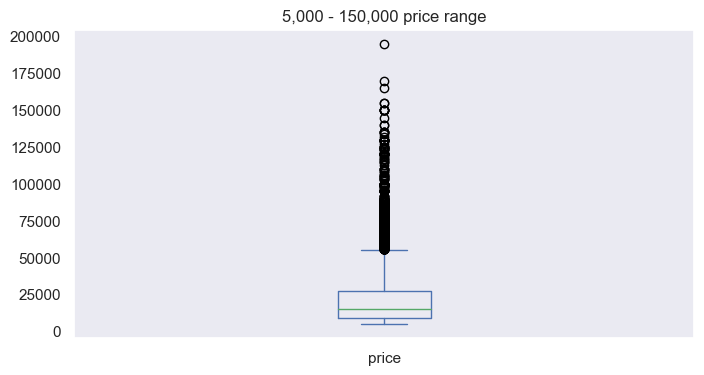

In [25]:
#filter data for price between 5k and 150k
df2 = df.loc[(df.price >= 5_000) & (df.price <= 200_000)]
sns.set()
fig,ax1=plt.subplots(figsize=(8,4))
df2.price.plot(kind='box')
ax1.set_title('5,000 - 150,000 price range')
plt.grid(False)

In [26]:
df2.price.max()

195000

In [27]:
df2.price.min()

5000

In [28]:
df2.shape

(81954, 15)

In [29]:
df2['odometer'].max()

10000000.0

In [30]:
df2.odometer.min()

0.0

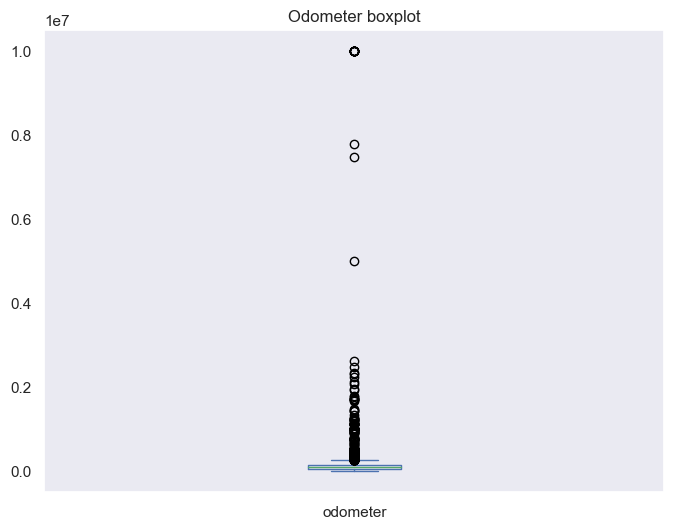

In [31]:
# use boxplots to find outliers in the odometer column
fig,ax = plt.subplots(figsize=(8,6))
df2.odometer.plot(kind='box')
plt.title('Odometer boxplot')
plt.grid(False)

There seems to be lots of outliers in the odometer readings. We can correct this by considering the average mileage driven per year by cars in the U.S which is **14,000 miles (22,500 km)**, and the **age** of the used vehicles to determine the upper and lower bounds for used car mileage. Assuming the minimum age of a used car is 2 years, we shall set the range of the odometer readings to between **45,000 km** and **500,000 km** (28,000 to 300,000 miles). 

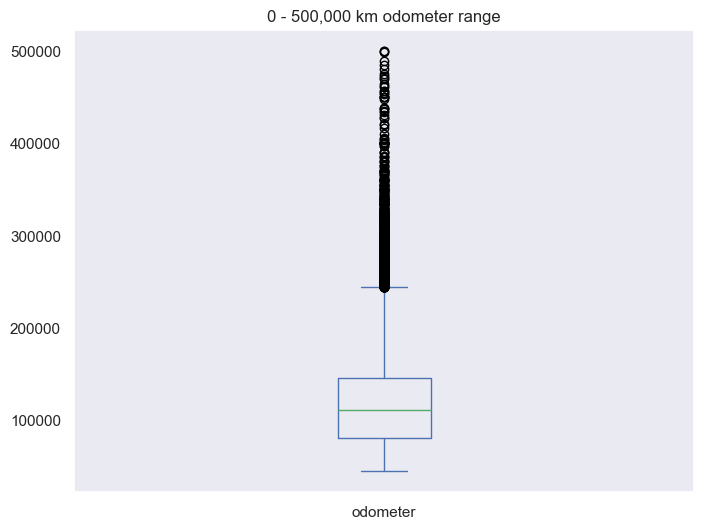

In [32]:
#filter data for odometer between 0 miles and 500,000 km
df2 = df2.loc[(df.odometer >= 45_000) & (df2.odometer <= 500_000)]
fig,(ax) = plt.subplots(figsize=(8,6))
df2.odometer.plot(kind='box')
ax.set_title('0 - 500,000 km odometer range')
plt.grid(None)

In [33]:
df2.shape

(61123, 15)

## Exploratory Data Analysis

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='title_status', ylabel='count'>

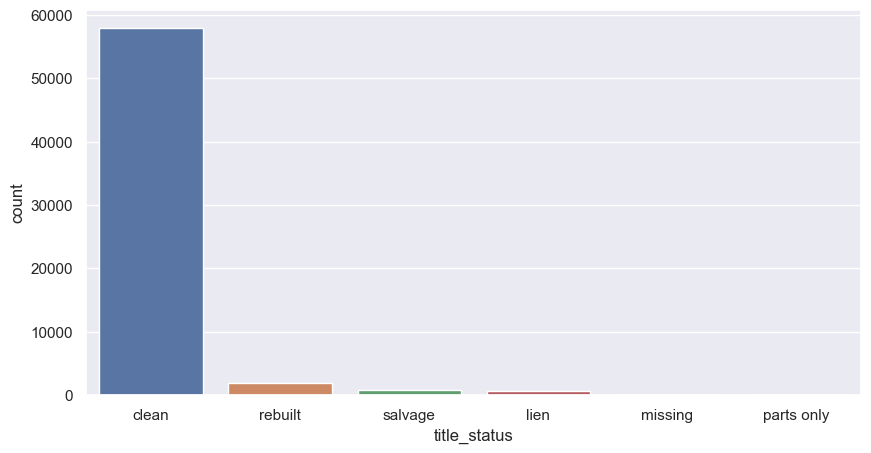

In [35]:
# plot showing the distribution of the title status
plt.figure(figsize=(10,5))
sns.countplot(df2['title_status'])

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='condition', ylabel='count'>

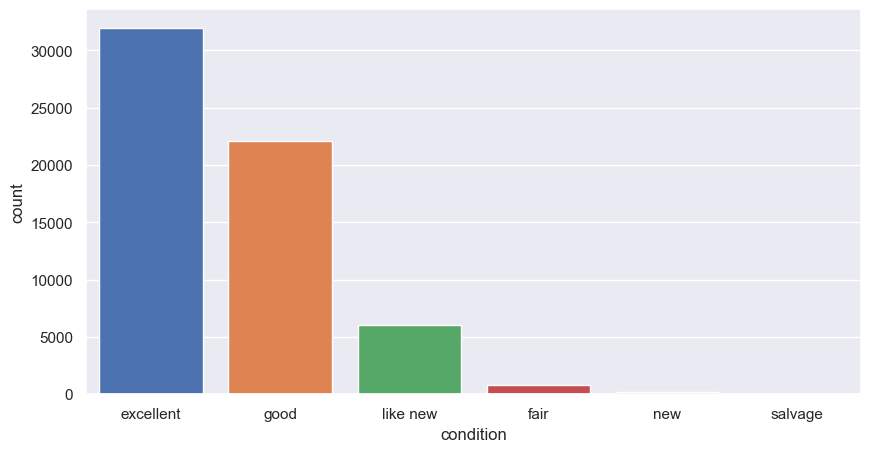

In [36]:
# plot showing the distribution of the various conditions of the vehicles
plt.figure(figsize=(10,5))
sns.countplot(df2.condition, saturation = 5)

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cylinders', ylabel='count'>

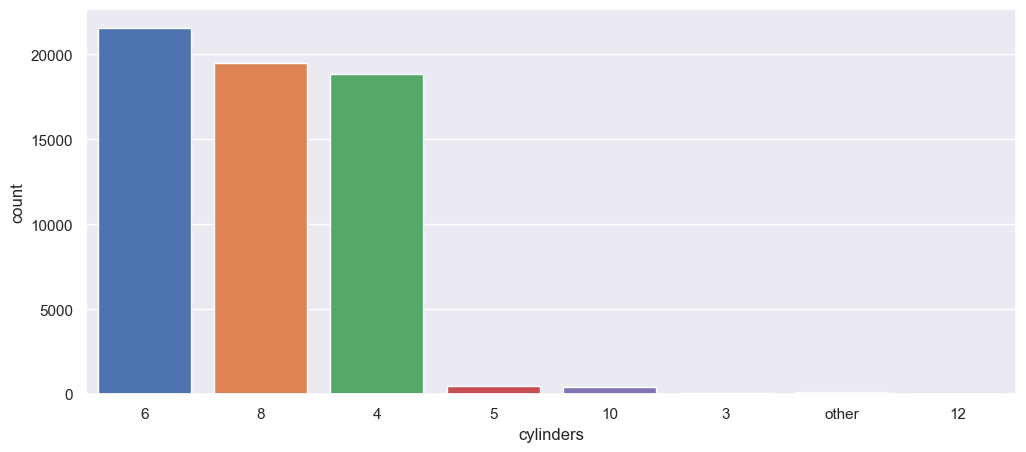

In [37]:
# plot showing the distribution of the different types of cylinders of the vehicles
plt.figure(figsize=(12,5))
sns.countplot(df2.cylinders, saturation = 8)

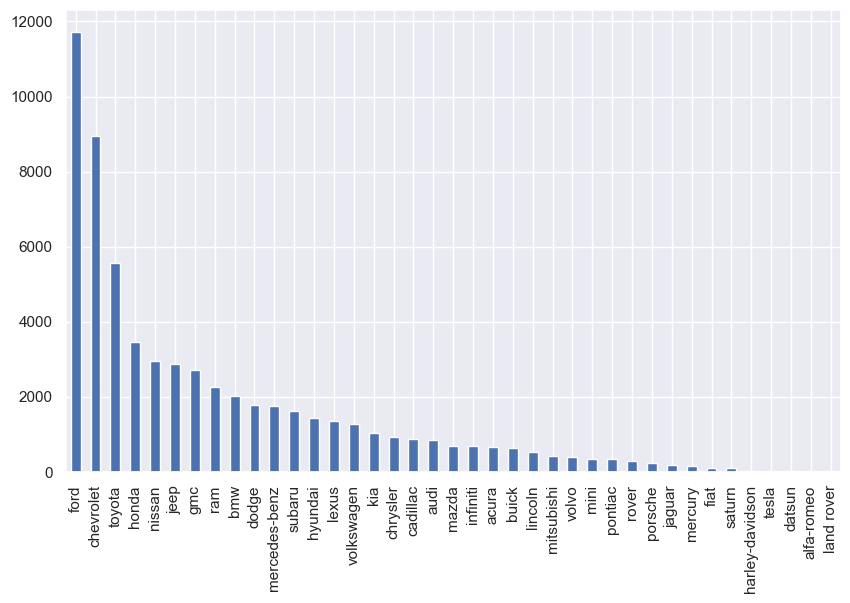

In [38]:
# plot showing the distribution of the different manufacturers of the vehicles
plt.figure(figsize = (10,6))
df2['manufacturer'].value_counts().plot(kind='bar')
plt.show()

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='paint_color', ylabel='count'>

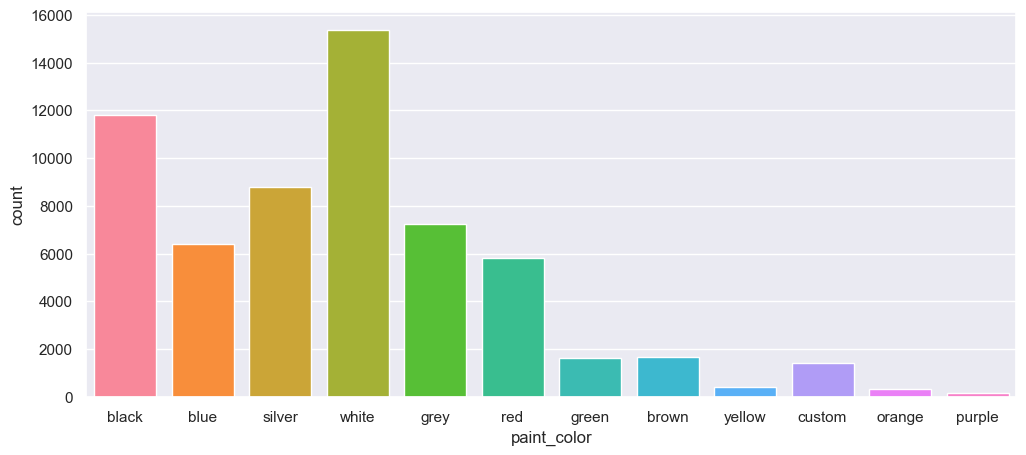

In [39]:
# plot showing the distribution of the different colors of the vehicles
plt.figure(figsize=(12,5))
sns.countplot(df2.paint_color, saturation = 8)

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='drive', ylabel='count'>

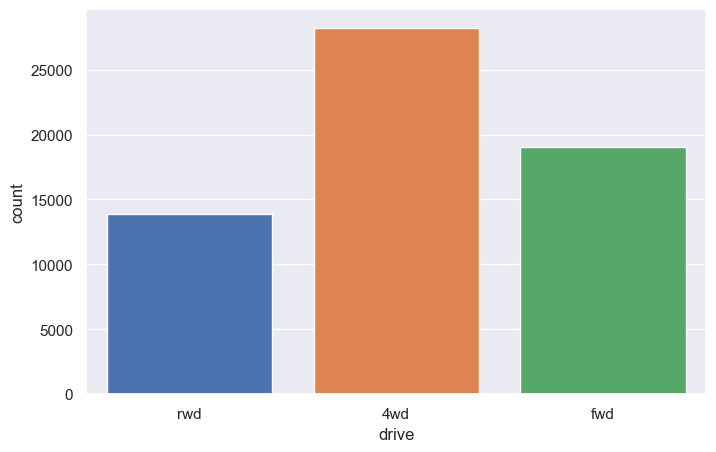

In [40]:
# plot showing the distribution of the different wheel drives of the vehicles
plt.figure(figsize=(8,5))
sns.countplot(df2.drive, saturation = 5)

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

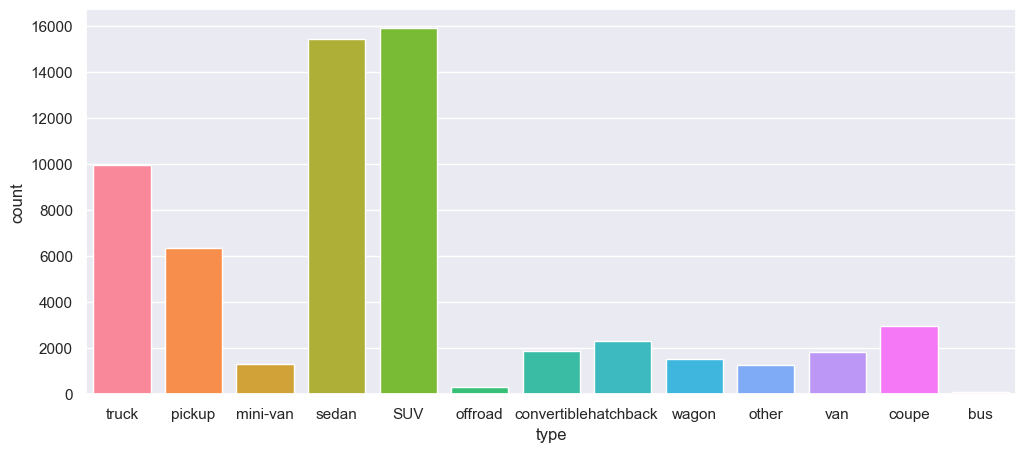

In [41]:
# plot showing the distribution of the different types of vehicles
plt.figure(figsize=(12,5))
sns.countplot(df2.type, saturation = 8)

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fuel', ylabel='count'>

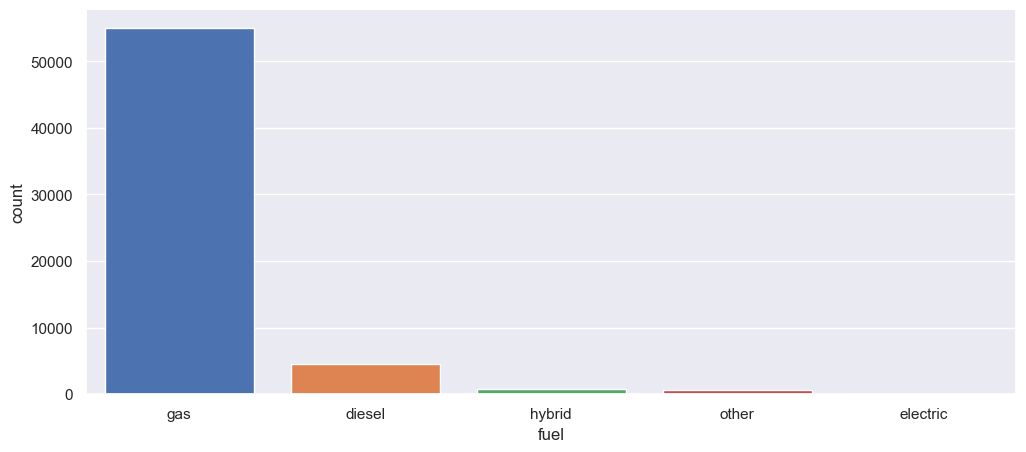

In [42]:
# plot showing the distribution of the different types of fuel
plt.figure(figsize=(12,5))
sns.countplot(df2.fuel, saturation = 8)

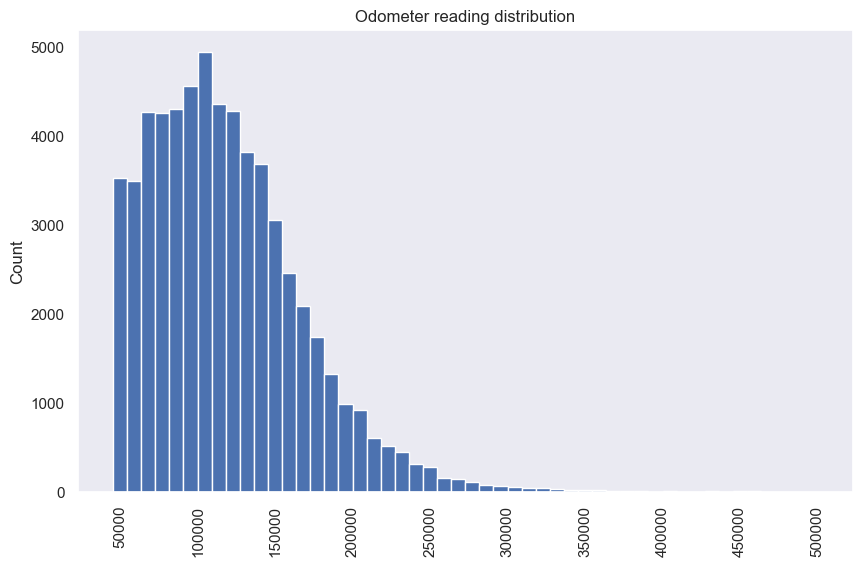

In [43]:
#check the odometer range 
fig,ax=plt.subplots(figsize=(10,6))
df2.odometer.hist(bins=50)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50000))
plt.title('Odometer reading distribution')
plt.grid(None)

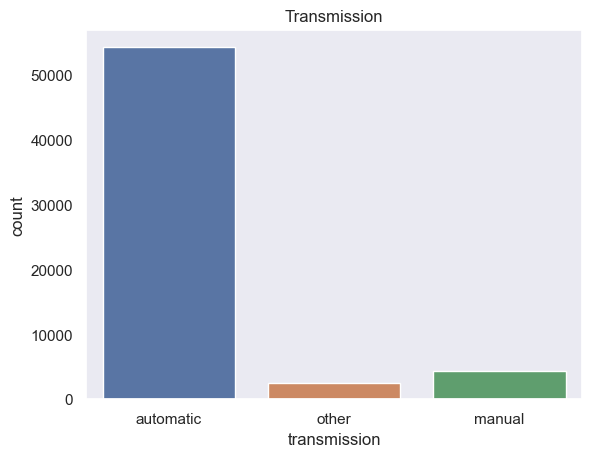

In [44]:
# check the distriution of vehicle transmissions 
sns.countplot(x='transmission',data=df2)
plt.title('Transmission')
plt.grid([])

In [46]:
# convert the year column from 'float64' to year type as 'int64'
df2['year'] = pd.to_datetime(df2['year'], errors='ignore', format='%y')

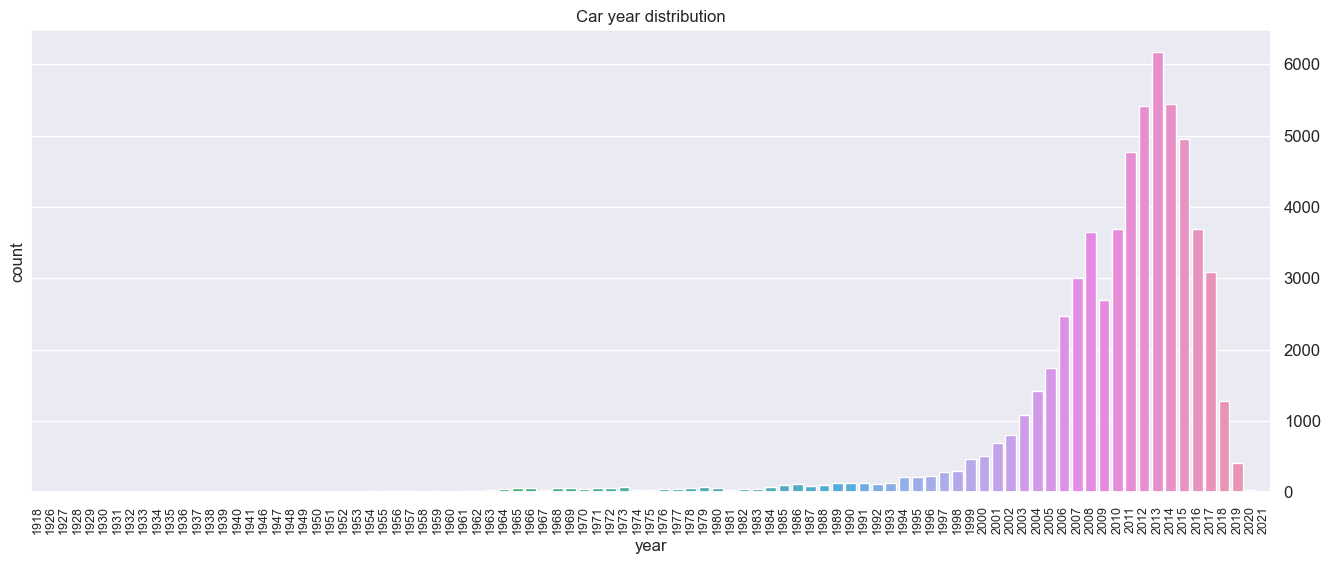

In [47]:
# plot showing the car year distribution
plt.figure(figsize=(16,6))
sns.countplot(x = 'year',data = df2)
plt.title('Car year distribution')
plt.tick_params(labelsize=12)
plt.xticks(fontsize=9,rotation=90)
plt.tick_params(axis='y', labelleft=False, labelright=True)
plt.show()

Distinguish older cars from newer ones. Create two new columns: age of cars by year, and average mileage of car per year

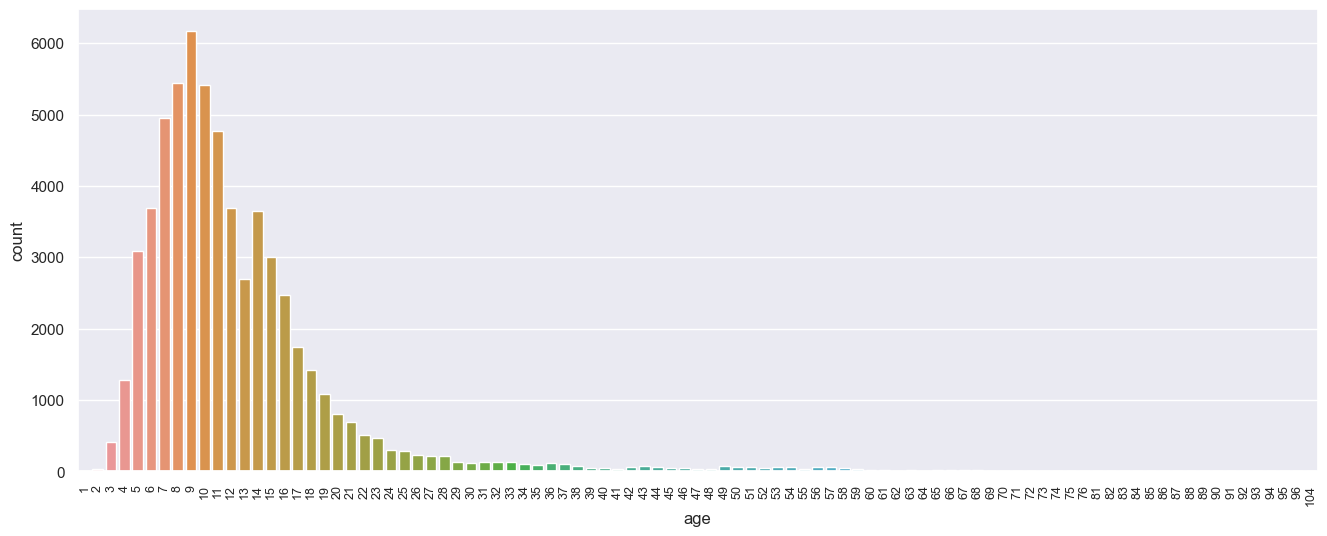

In [48]:
# create Age column
df2['age'] = 2021 - (df2['year'] - 1)

# plot Age distribution
plt.figure(figsize = (16,6))
sns.set()
sns.countplot(x ='age', data = df2)
plt.xticks(fontsize = 9, rotation = 90)
plt.show()

In [49]:
#take out the 0-1 year old cars
df2 = df2.loc[~(df2.age < 2)]

In [50]:
# create average mileage per year column
df2['avg_mileage'] = df2['odometer'] / df2['age']
df2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age,avg_mileage
31,auburn,15000,2013,ford,f-150 xlt,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,al,9,14222.222222
32,auburn,27990,2012,gmc,sierra 2500 hd extended cab,good,8,gas,68696.0,clean,other,4wd,pickup,black,al,10,6869.600000
55,auburn,19900,2004,ford,f250 super duty,good,8,diesel,88000.0,clean,automatic,4wd,pickup,blue,al,18,4888.888889
59,auburn,14000,2012,honda,odyssey,excellent,6,gas,95000.0,clean,automatic,fwd,mini-van,silver,al,10,9500.000000
65,auburn,22500,2001,ford,f450,good,8,diesel,144700.0,clean,manual,rwd,truck,white,al,21,6890.476190


In [52]:
df2.shape

(61121, 17)

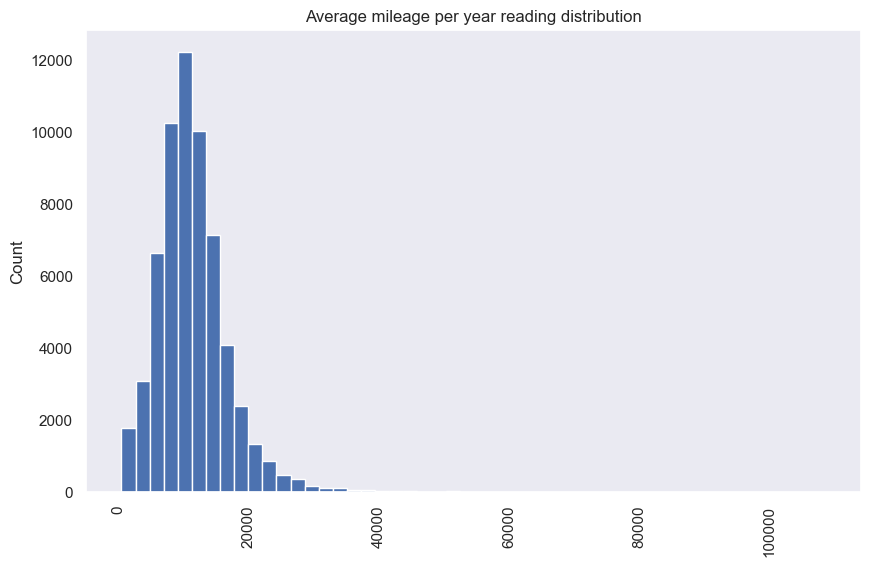

In [55]:
# check the average mileage range 
fig,ax = plt.subplots(figsize = (10,6))
df2.avg_mileage.hist(bins = 50)
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Average mileage per year reading distribution')
plt.grid(None)

In [ ]:
plt.figure(figsize = (13, 5))
sns.heatmap(df.corr(),annot=True)
plt.title('Fig: Correlation map', y=-0.23)